# Setup

This is just some python magic to make running scripts faster and plotting nicer.

In [1]:
import numpy as np, pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 16,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
    'font.family':"sans-serif",
   'font.sans-serif':'Arial',
   'text.usetex': False,
   }

rcParams.update(params)

Let's load the MNIST dataset

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

def get_variable(shape):
    initial = tf.random_normal(shape)
    return tf.Variable(initial)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# Regularization

In [3]:
def regularize(loss, weights, reg_kind=None, reg_value=None, chain=1, discount=0.9,stride=1):
    if reg_kind is None:
        return loss
    elif reg_kind=='L1':
        print("Adding L1 regularization")
        return loss + reg_value*tf.reduce_mean(tf.abs(weights))
    elif reg_kind=='DZ':    
        print("Adding DZ regularization")
        return loss + reg_value*DZ_reg(weights,chain,discount,stride)
    elif reg_kind=='DZ2D':    
        print("Adding DZ2D-regularization")
        return loss + reg_value*DZ_reg2D(weights,chain,discount,stride)
    elif reg_kind=='DZ+L1':    
        print("Adding DZ+L1 regularization")
        return loss + reg_value[0]*DZ_reg(weights,chain,discount,stride)+reg_value[1]*tf.reduce_mean(tf.abs(weights))
    elif reg_kind=='DZ2D+L1':    
        print("Adding DZ2D+L1 regularization")
        return loss + reg_value[0]*DZ_reg2D(weights,chain,discount,stride)+reg_value[1]*tf.reduce_mean(tf.abs(weights))  
    else:
        raise ValueError("Invalid value for parameter: reg_kind")

In [4]:
def DZ_reg(weights,chain=1,discount=0.9,stride=1):
    d1,d2=weights.shape
    d1,d2=int(d1),int(d2)
    n_chan= d2//d1
    weights = tf.reshape(weights,[d1,d1,n_chan])
    result = 0
    for i in np.arange(chain):
        weights_rolled=tf.manip.roll(weights, shift=[-stride*(i+1),-stride*(i+1)], axis=[0,1])
        result += tf.reduce_mean(tf.abs(weights_rolled-weights))*(discount**i)
    return result

In [6]:
def DZ_reg2D(weights,chain=1,discount=0.9,stride=1):
    result = 0
    for i in np.arange(chain):
        weights_rolled_1=tf.manip.roll(weights, shift=[-stride*(i+1),-(i+1)], axis=[0,2]) #shift=[-4,-1]
        weights_rolled_2=tf.manip.roll(weights, shift=[-stride*(i+1),-stride*(i+1)], axis=[1,3])
        result += tf.reduce_mean(tf.square(weights_rolled_1-weights))*(discount**i)+tf.reduce_mean(tf.square(weights_rolled_2-weights))*(discount**i)        
    return result


# Fully Connected

The architecture is: FC-49 | FC-10
 
To increase flexibility, I have included a parameter called ``num_channels``. By changing this parameter, one can increase the number of weights. For example, if ``num_channels`` is 3, then the architecture is:

The architecture is: FC-147 | FC-10

In [8]:
def fully_connected2D(pool=4, num_channels=10, verbose=True, return_weights=False, reg_kind=None, reg_value=None, chain=1, discount=0.9,stride=1):
    
    d = int(784/pool/pool)
    x = tf.placeholder(tf.float32, [None, 784])
    H_dim = 7
    #hidden layer
    W_fc1 = get_variable([28,28, H_dim,H_dim,num_channels])
    b_fc1 = get_variable([H_dim,H_dim,num_channels])

    x_reshaped = tf.reshape(x, [-1, 28, 28, 1])
    #x_reshaped = tf.nn.max_pool(x_reshaped, [1, pool, pool,1], [1, pool, pool, 1], padding='SAME')
    #x_reshaped = tf.reshape(x_reshaped, [-1, d])
    h_fc1 = tf.sigmoid(tf.tensordot(x_reshaped, W_fc1, axes= [[1,2],[0,1]]) + b_fc1)
    h_fc1 = tf.reshape(h_fc1,[-1,H_dim*H_dim*num_channels] )
    
    #output layer
    W_fc2 = get_variable([H_dim*H_dim*num_channels, 10])
    # W_fc2 = weight_variable([7840, 10])
    b_fc2 = get_variable([10])
    y = tf.matmul(h_fc1, W_fc2) + b_fc2

    y_ = tf.placeholder(tf.float32, [None, 10])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    loss = regularize(loss, W_fc1, reg_kind, reg_value, chain, discount,stride)
    train_step = tf.train.GradientDescentOptimizer(3.0).minimize(loss)

    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        for i in range(1000):
            batch = mnist.train.next_batch(100)
            train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if i%100==0:
                accuracy_train = accuracy.eval(feed_dict={x: mnist.train.images, y_: mnist.train.labels})
                accuracy_valid = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                if verbose:
                    print('Train acc:',accuracy_train, 'Valid acc:',accuracy_valid)
        
        return_values = [accuracy_train, accuracy_valid]
        if return_weights:
            return_values.append(sess.run(W_fc1))
        
    return return_values

In [9]:
def visualize_weights2D(weights, num_channels,num_channels_init=0, num_digits=5):
    weights = np.abs(weights) # we care about magnitude
    for k in np.arange(num_channels_init,num_channels):
        fig, axes = plt.subplots(7,7,  figsize=[ 7,7])
        for i in range(7):
            for j in range(7):
                axes[i,j].imshow(weights[:, :, i,j,k], cmap='gray', vmin=0, vmax=np.amax([np.max(weights[:, :, i,j,k]),0.03]  ))
                


In [10]:
accuracy_train, accuracy_valid, weights = fully_connected2D(num_channels=32,return_weights=True,reg_kind='DZ2D+L1',reg_value=[1000,100],chain=10)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Adding DZ2D+L1 regularization
Train acc: 0.099454544 Valid acc: 0.1032
Train acc: 0.38596365 Valid acc: 0.3825
Train acc: 0.37478182 Valid acc: 0.3715
Train acc: 0.63969094 Valid acc: 0.6338
Train acc: 0.43767273 Valid acc: 0.4283
Train acc: 0.33276364 Valid acc: 0.3311
Train acc: 0.61572725 Valid acc: 0.6222
Train acc: 0.3987091 Valid acc: 0.3909
Train acc: 0.6249273 Valid acc: 0.6206
Train acc: 0.37847272 Valid acc: 0.3758


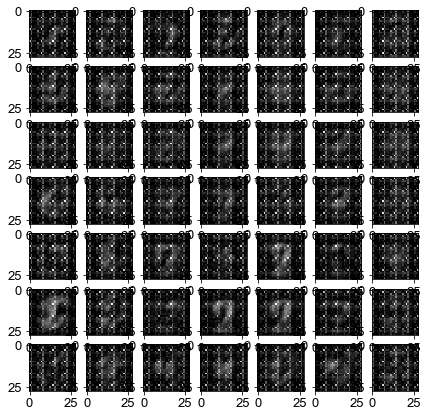

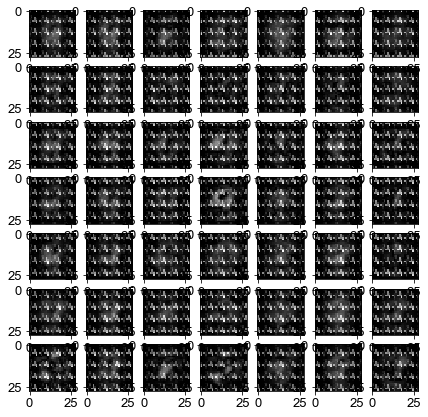

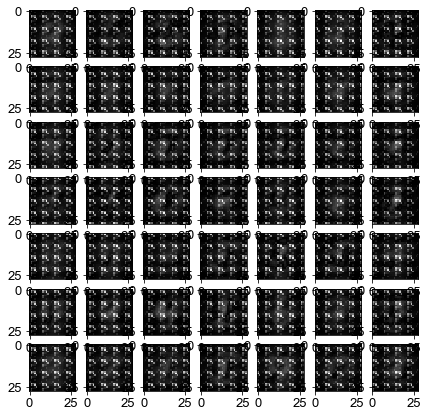

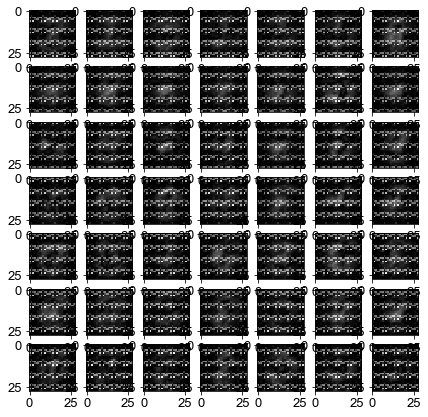

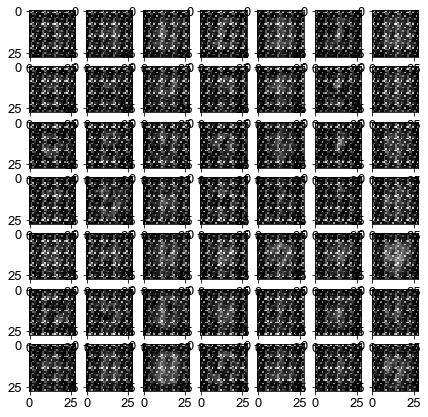

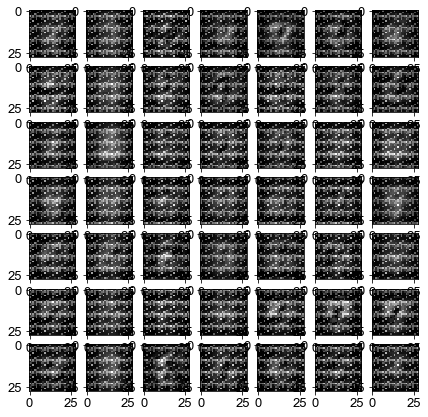

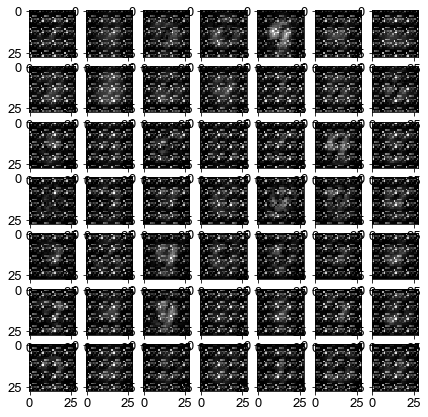

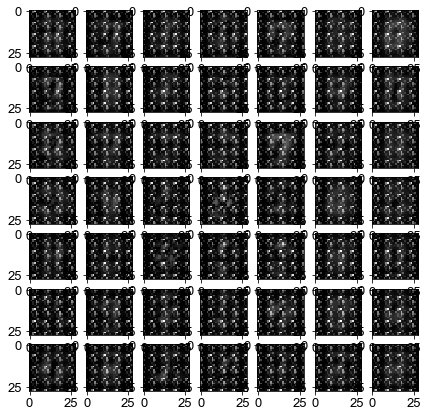

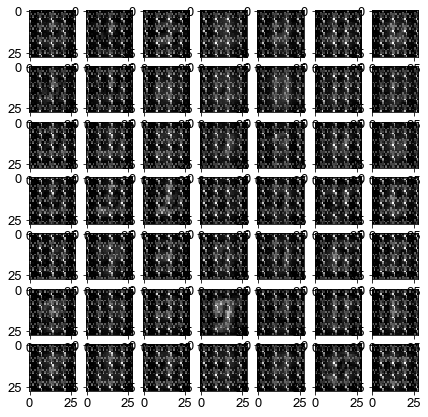

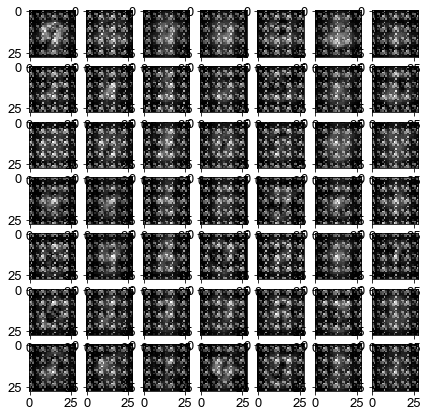

In [13]:
visualize_weights2D(weights,num_channels=10)

In [14]:
def visualize_weights2D(weights, num_channels,num_channels_init=0, num_digits=5):
    weights = np.abs(weights) # we care about magnitude
    for k in np.arange(num_channels_init,num_channels):
        fig, axes = plt.subplots(7,7,  figsize=[ 7,7])
        for i in range(7):
            for j in range(7):
                axes[i,j].imshow(weights[:7, :7, i,j,k], cmap='gray', vmin=0, vmax=np.amax([np.max(weights[:, :, i,j,k]),0.03]  ))

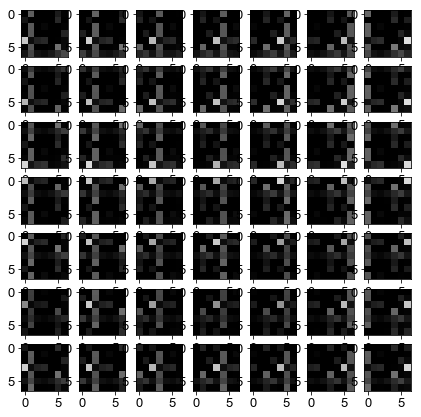

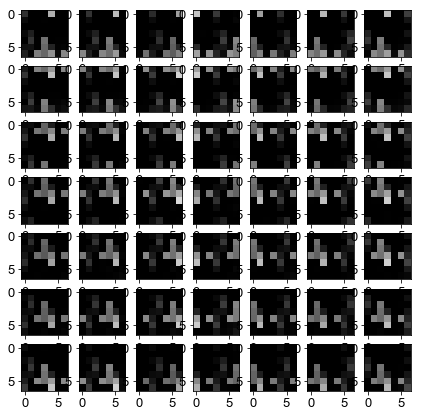

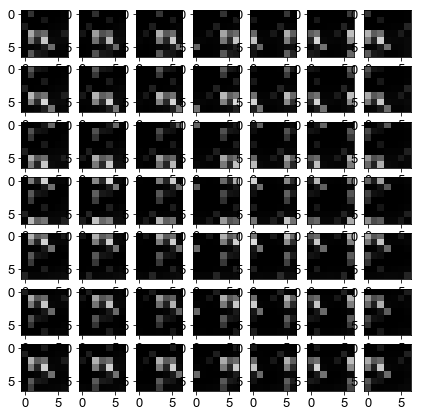

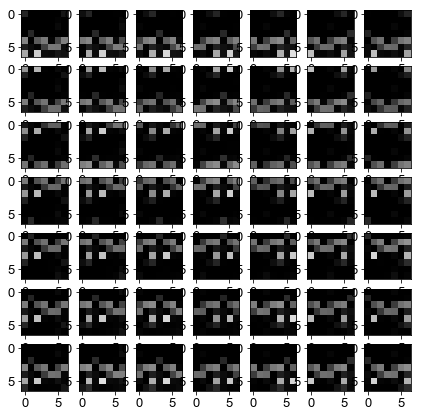

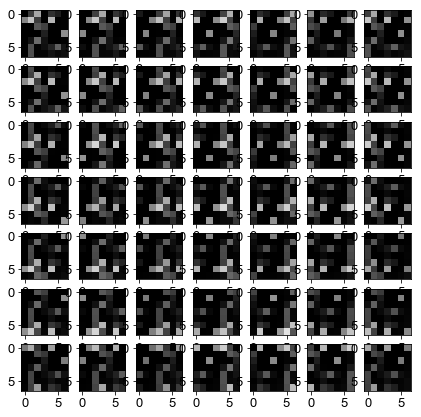

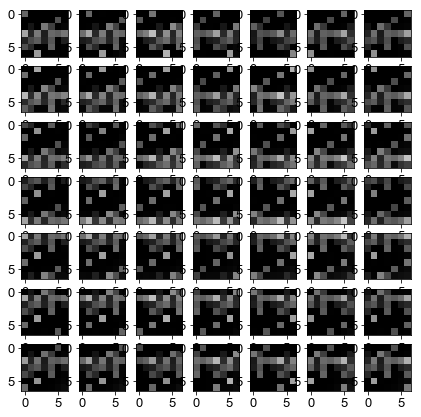

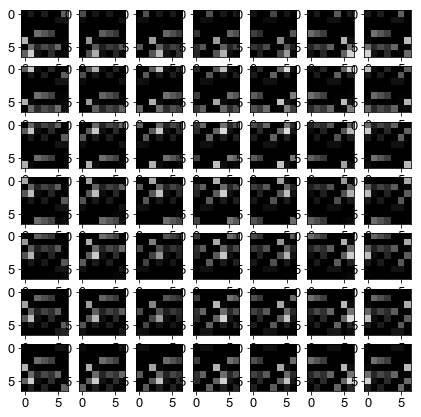

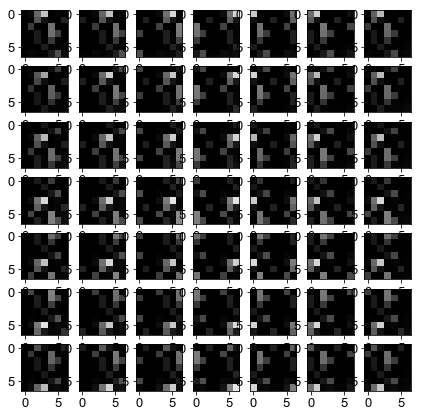

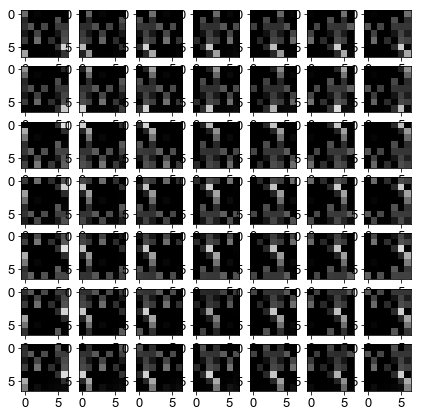

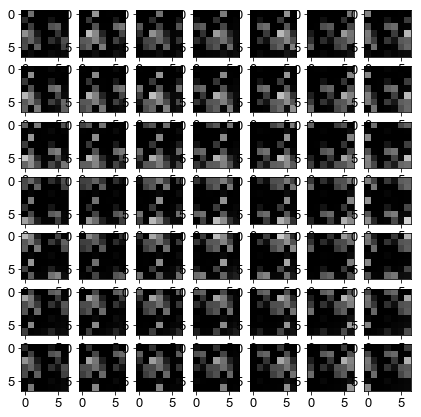

In [15]:
visualize_weights2D(weights,num_channels=10)

In [16]:
def visualize_weights2D(weights, num_channels,num_channels_init=0, num_digits=5):
    weights = np.abs(weights) # we care about magnitude
    for k in np.arange(num_channels_init,num_channels):
        fig, axes = plt.subplots(7,7,  figsize=[ 7,7])
        for i in range(7):
            for j in range(7):
                axes[i,j].imshow(weights[:, :, i,j,k], cmap='gray', vmin=0, vmax=np.amax([np.max(weights[:, :, i,j,k]),0.03]  ))
                


Adding DZ2D+L1 regularization
Train acc: 0.11543636 Valid acc: 0.1165
Train acc: 0.89765453 Valid acc: 0.8948
Train acc: 0.9259818 Valid acc: 0.9175
Train acc: 0.9244182 Valid acc: 0.9167
Train acc: 0.9329818 Valid acc: 0.9192
Train acc: 0.9472727 Valid acc: 0.9334
Train acc: 0.95247275 Valid acc: 0.9432
Train acc: 0.9520909 Valid acc: 0.9404
Train acc: 0.9308182 Valid acc: 0.918
Train acc: 0.96041816 Valid acc: 0.948


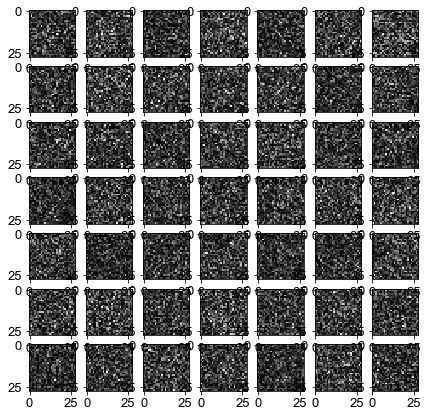

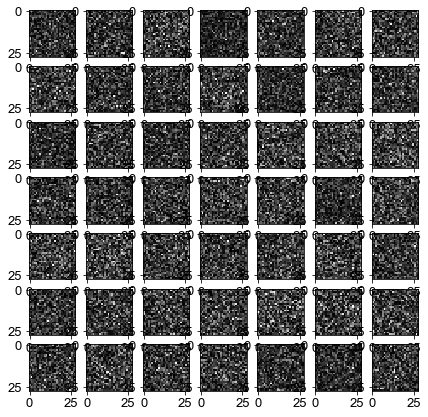

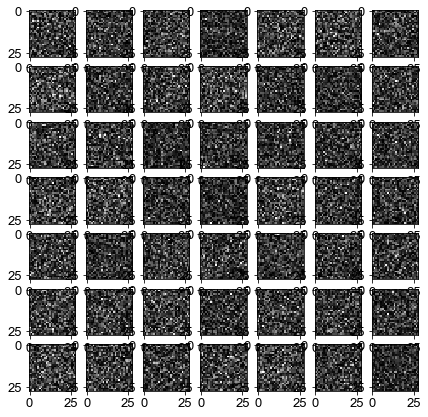

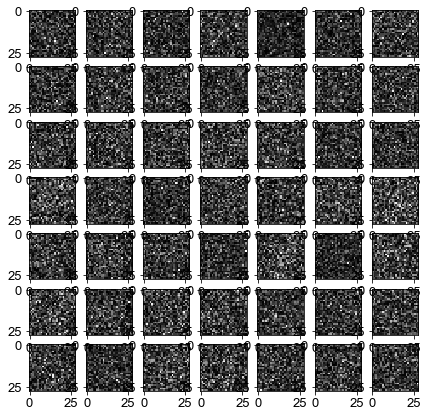

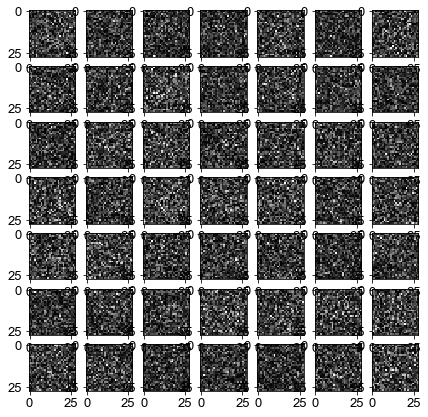

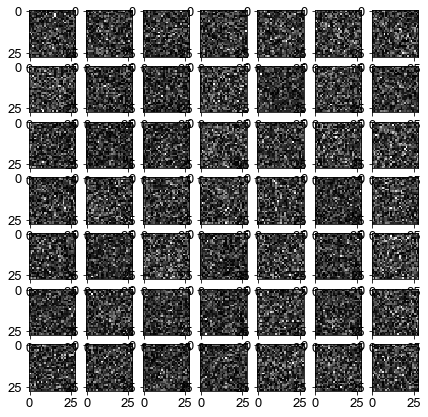

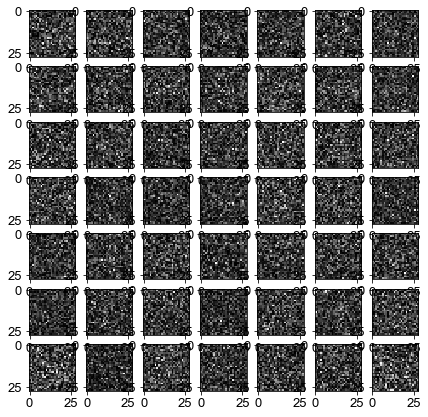

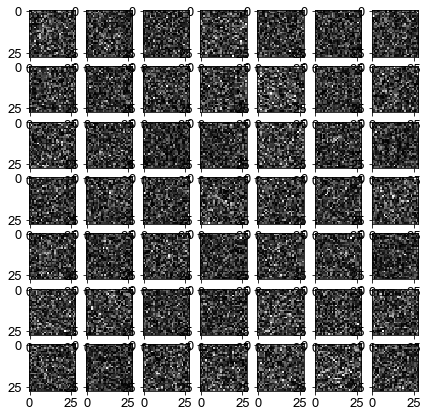

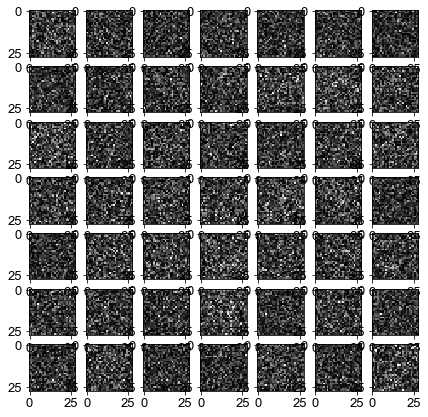

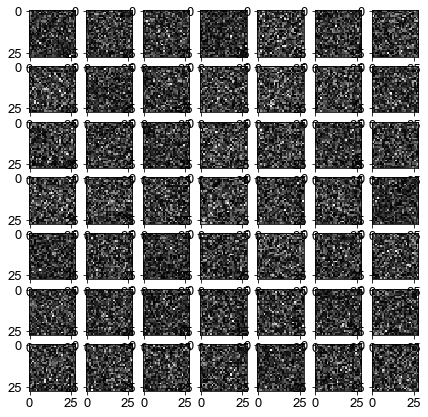

In [17]:
accuracy_train, accuracy_valid, weights = fully_connected2D(num_channels=32,return_weights=True,reg_kind='DZ2D+L1',reg_value=[10,10],chain=10)

visualize_weights2D(weights,num_channels=10)

Adding DZ2D+L1 regularization
Train acc: 0.2648182 Valid acc: 0.2658
Train acc: 0.48521817 Valid acc: 0.4948
Train acc: 0.6065091 Valid acc: 0.6095
Train acc: 0.43121818 Valid acc: 0.4327
Train acc: 0.4399091 Valid acc: 0.4409
Train acc: 0.5646 Valid acc: 0.5564
Train acc: 0.37801817 Valid acc: 0.3661
Train acc: 0.48892727 Valid acc: 0.4905
Train acc: 0.5530364 Valid acc: 0.5399
Train acc: 0.4447091 Valid acc: 0.4457


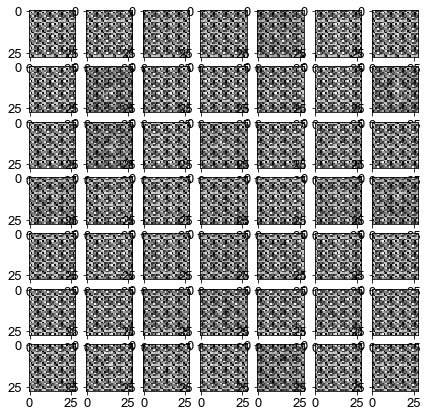

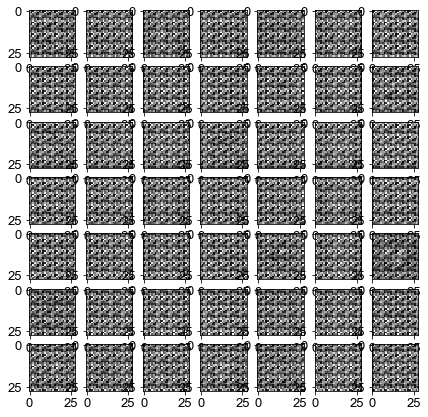

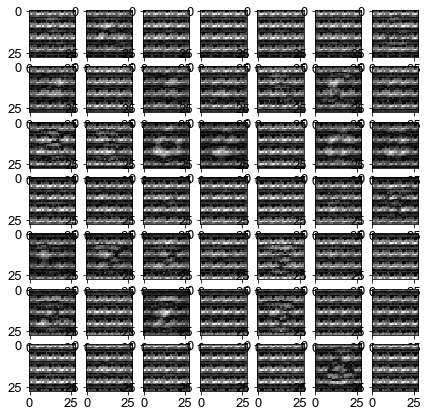

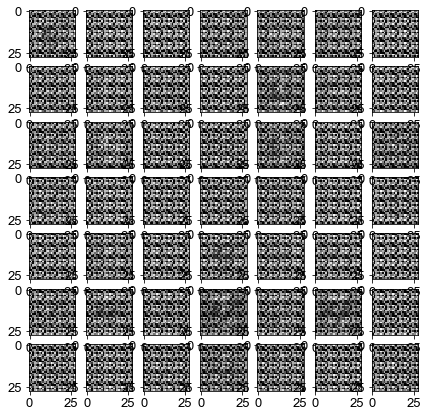

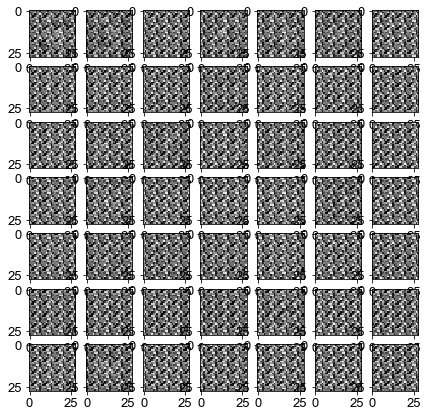

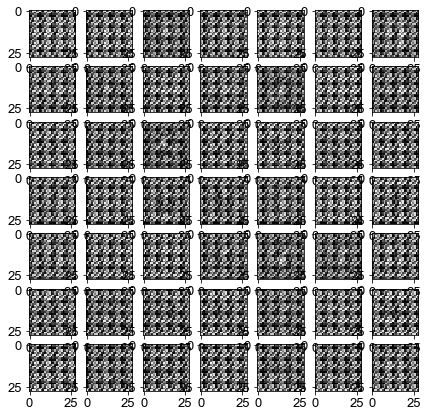

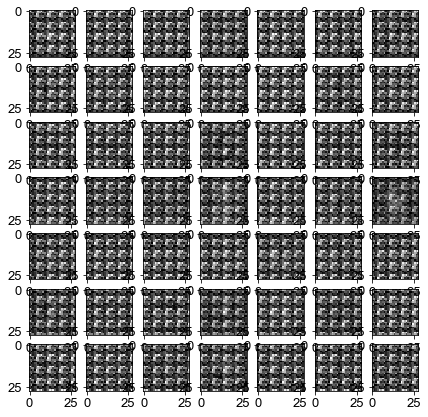

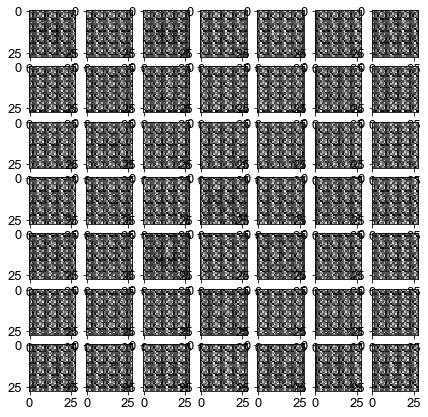

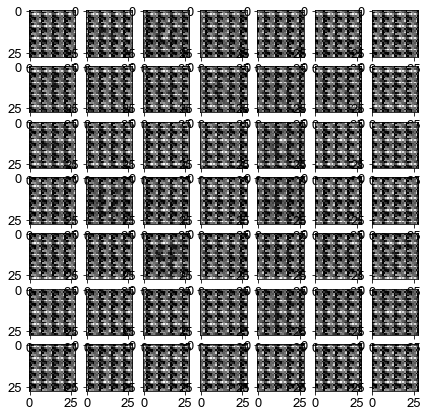

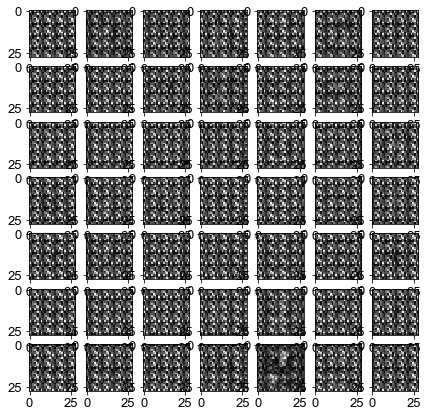

In [18]:
accuracy_train, accuracy_valid, weights = fully_connected2D(num_channels=32,return_weights=True,reg_kind='DZ2D+L1',reg_value=[1000,10],chain=10)

visualize_weights2D(weights,num_channels=10)

In [19]:
accuracy_train, accuracy_valid, weights = fully_connected2D(num_channels=12,return_weights=True,reg_kind='DZ2D+L1',reg_value=[100,100],chain=10)

Adding DZ2D+L1 regularization
Train acc: 0.101654544 Valid acc: 0.0986
Train acc: 0.62807274 Valid acc: 0.6279
Train acc: 0.6446 Valid acc: 0.643
Train acc: 0.6896 Valid acc: 0.6925
Train acc: 0.58056366 Valid acc: 0.5815
Train acc: 0.7678 Valid acc: 0.7751
Train acc: 0.7152909 Valid acc: 0.7204
Train acc: 0.5635818 Valid acc: 0.5746
Train acc: 0.7477818 Valid acc: 0.7492
Train acc: 0.60981816 Valid acc: 0.6199


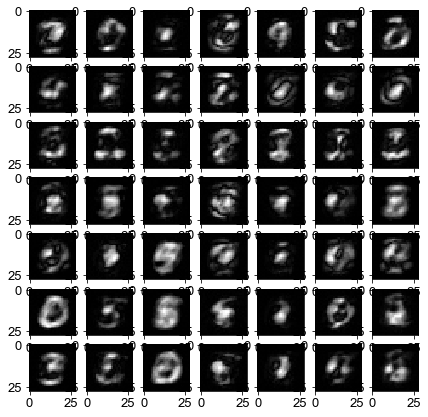

In [20]:
visualize_weights2D(weights,num_channels_init=4,num_channels=5)

Adding DZ2D+L1 regularization
Train acc: 0.10549091 Valid acc: 0.1042
Train acc: 0.9025091 Valid acc: 0.9006
Train acc: 0.9170182 Valid acc: 0.9106
Train acc: 0.9117091 Valid acc: 0.8985
Train acc: 0.94045454 Valid acc: 0.9296
Train acc: 0.95476365 Valid acc: 0.9412
Train acc: 0.9579818 Valid acc: 0.9397
Train acc: 0.9670727 Valid acc: 0.9494
Train acc: 0.9662727 Valid acc: 0.9475
Train acc: 0.97312725 Valid acc: 0.9536


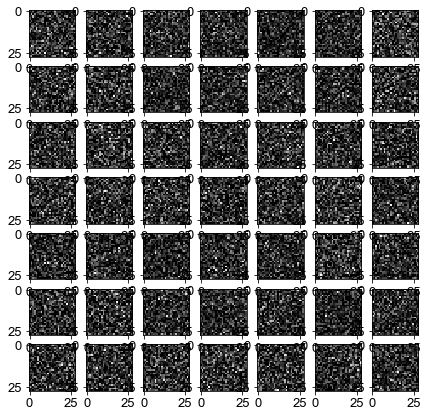

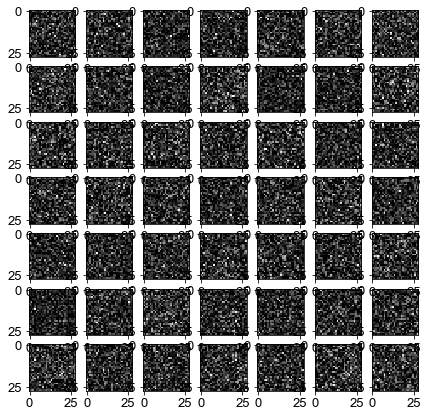

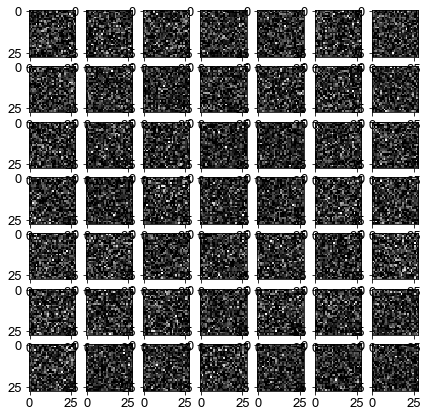

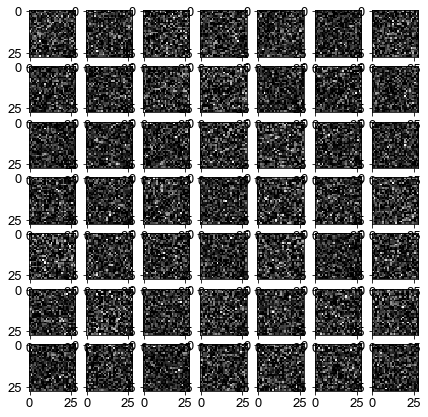

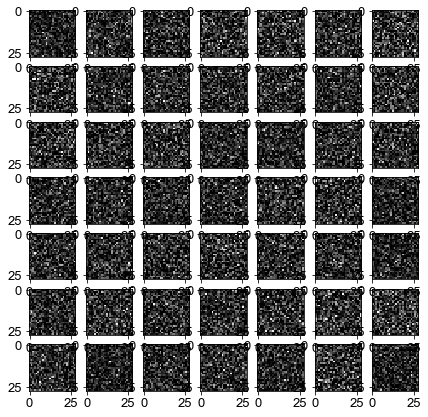

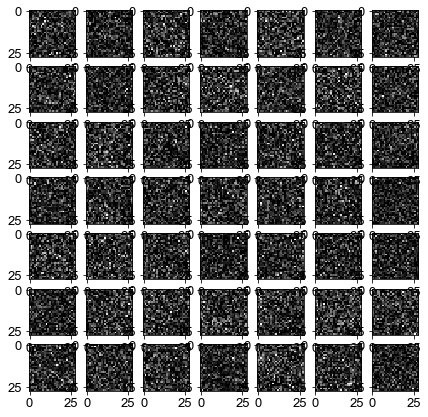

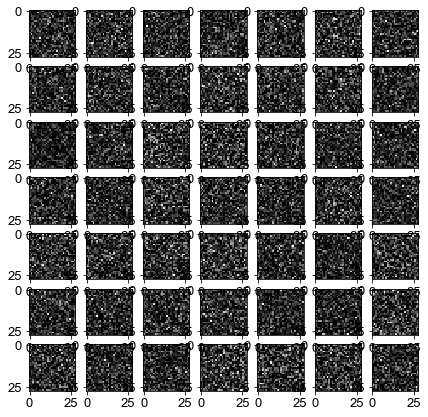

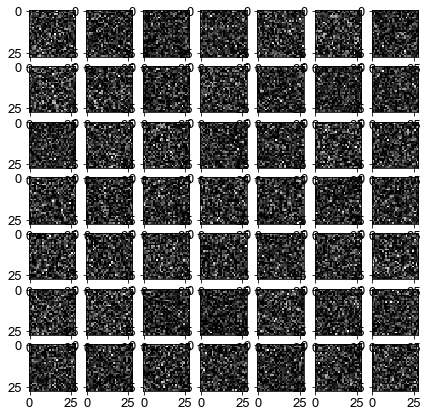

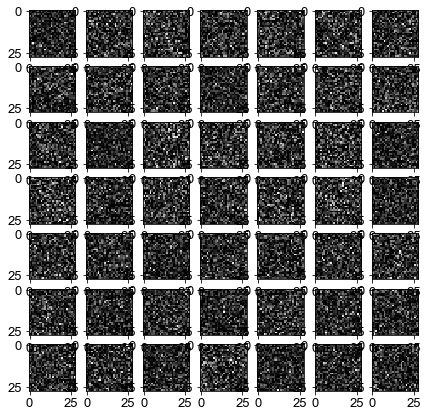

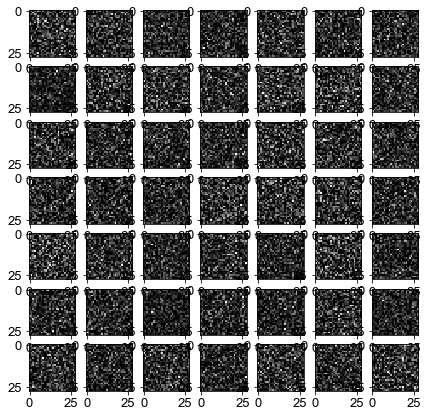

In [21]:
accuracy_train, accuracy_valid, weights = fully_connected2D(num_channels=32,return_weights=True,reg_kind='DZ2D+L1',reg_value=[1,100],chain=10)

visualize_weights2D(weights,num_channels=10)

In [22]:
mnist = input_data.read_data_sets("FASHION_data/", one_hot=True)

def get_variable(shape):
    initial = tf.random_normal(shape)
    return tf.Variable(initial)

Extracting FASHION_data/train-images-idx3-ubyte.gz
Extracting FASHION_data/train-labels-idx1-ubyte.gz
Extracting FASHION_data/t10k-images-idx3-ubyte.gz
Extracting FASHION_data/t10k-labels-idx1-ubyte.gz


In [23]:
def fully_connected2D(pool=4, num_channels=10, verbose=True, return_weights=False, reg_kind=None, reg_value=None, chain=1, discount=0.9,stride=1):
    
    d = int(784/pool/pool)
    x = tf.placeholder(tf.float32, [None, 784])
    H_dim =7
    #hidden layer
    W_fc1 = get_variable([28,28, H_dim,H_dim,num_channels])
    b_fc1 = get_variable([H_dim,H_dim,num_channels])
    # W_fc1 = weight_variable([784, 7840])
    # b_fc1 = bias_variable([7840])
    x_reshaped = tf.reshape(x, [-1, 28, 28, 1])
    #x_reshaped = tf.nn.max_pool(x_reshaped, [1, pool, pool,1], [1, pool, pool, 1], padding='SAME')
    #x_reshaped = tf.reshape(x_reshaped, [-1, d])
    h_fc1 = tf.sigmoid(tf.tensordot(x_reshaped, W_fc1, axes= [[1,2],[0,1]]) + b_fc1)
    h_fc1 = tf.reshape(h_fc1,[-1,H_dim*H_dim*num_channels] )
    
    #output layer
    W_fc2 = get_variable([H_dim*H_dim*num_channels, 10])
    # W_fc2 = weight_variable([7840, 10])
    b_fc2 = get_variable([10])
    y = tf.matmul(h_fc1, W_fc2) + b_fc2

    y_ = tf.placeholder(tf.float32, [None, 10])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    loss = regularize(loss, W_fc1, reg_kind, reg_value, chain, discount,stride)
    train_step = tf.train.GradientDescentOptimizer(3.0).minimize(loss)

    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        for i in range(2500):
            batch = mnist.train.next_batch(100)
            train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if i%100==0:
                accuracy_train = accuracy.eval(feed_dict={x: mnist.train.images, y_: mnist.train.labels})
                accuracy_valid = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                if verbose:
                    print('Train acc:',accuracy_train, 'Valid acc:',accuracy_valid)
        
        return_values = [accuracy_train, accuracy_valid]
        if return_weights:
            return_values.append(sess.run(W_fc1))
        
    return return_values

In [24]:
accuracy_train, accuracy_valid, weights = fully_connected2D(num_channels=32,return_weights=True,reg_kind='DZ2D+L1',reg_value=[50,50],chain=10)

Adding DZ2D+L1 regularization
Train acc: 0.10932727 Valid acc: 0.1104
Train acc: 0.60227275 Valid acc: 0.5917
Train acc: 0.6581636 Valid acc: 0.656
Train acc: 0.67456365 Valid acc: 0.6646
Train acc: 0.59401816 Valid acc: 0.5835
Train acc: 0.6418909 Valid acc: 0.6326
Train acc: 0.71465456 Valid acc: 0.7049
Train acc: 0.6914909 Valid acc: 0.6897
Train acc: 0.7089818 Valid acc: 0.6989
Train acc: 0.7671818 Valid acc: 0.754
Train acc: 0.6737273 Valid acc: 0.6638
Train acc: 0.6532909 Valid acc: 0.6421
Train acc: 0.28649092 Valid acc: 0.2835
Train acc: 0.5572909 Valid acc: 0.5541
Train acc: 0.6088182 Valid acc: 0.604
Train acc: 0.72492725 Valid acc: 0.7161
Train acc: 0.6959091 Valid acc: 0.683
Train acc: 0.6864182 Valid acc: 0.6843
Train acc: 0.6963818 Valid acc: 0.6885
Train acc: 0.76616365 Valid acc: 0.7593
Train acc: 0.35529092 Valid acc: 0.3536
Train acc: 0.5547091 Valid acc: 0.5491
Train acc: 0.6065636 Valid acc: 0.5961
Train acc: 0.49336365 Valid acc: 0.489
Train acc: 0.6119273 Valid ac

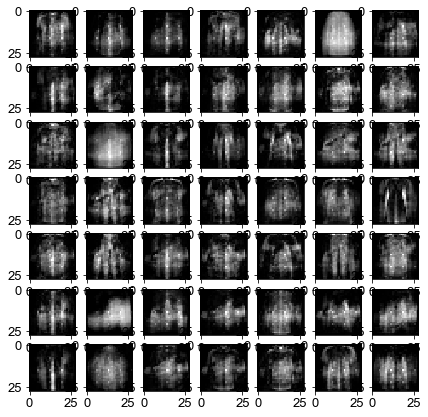

In [25]:
visualize_weights2D(weights,num_channels=1)